Title: EM on 1D Mixture Densities
Author: Thomas Breuel
Institution: UniKL

In [2]:

import pylab
from pylab import *
from scipy import random
from scipy.stats import distributions

# Expectation Maximization for Mixture Densities

The EM algorithm is a common algorithm used for estimating mixture
densities.
More generally, it is used in which estimating something requires
some "hidden" variables that we can't observe.
The idea is that we start with a guess for the hidden variables,
perform our estimate, and then use the estimate itself to update
the hidden variables.

Let's start by generating a mixture distribution. 

We have two component mixtures, one with a mean of 0 and variance of 1, the other with a mean of 5 and variance of 4.  The first mixture component is chosen with probability 0.3, the second with probability 0.7.



In [3]:
data1 = random.normal(loc=0.0,scale=1.0,size=3000)
data2 = random.normal(loc=5.0,scale=2.0,size=7000)
data = concatenate((data1,data2))
random.shuffle(data)
n = len(data)

The mixture density has the form:

$$ p(x) = p_0 {\cal N}(x;\mu_0,\sigma^2_0) + p_1 {\cal N}(x;\mu_1,\sigma^2_1) $$

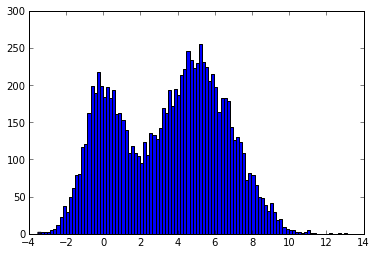

In [4]:
_=hist(data,bins=100)

We need the formula for the normal density.



In [5]:
def normal(x,params):
    mu = params[0]
    var = params[1]
    return exp(-(x-mu)**2/(2*var))/sqrt(2*pi*var)

Let's pretend we already know the solution parameters $\theta$ approximately.
These parameters are the means and variances of each mixture component.
We represent them as a matrix $\theta = {{\mu_0 \sigma^2_0}\choose{\mu_1 \sigma^2_1}}$.
Let's pretend we also know the probabilities of the mixture components $a = (p_0,p_1)$.



In [6]:
thetas = array([[0.0,1.0],[1.0,1.0]])
mixes = array([0.5,0.5])

Assuming these parameters are correct, we can compute the probabilities that each of our data samples comes from mixture component 0 or mixture component 1.  This is a simple application of Bayes formula:

$$p(c|x) = \frac{p(x|c) p(c)}{p(x)}$$

Of course, we don't actually know the precise distributions, so we just estimate these:

$$ \hat{y}_{i,j} = p(c=i|x_j) $$

This is called the expectation step of the EM algorithm. 

The reason is that the true membership variables $y_{i,j}$ are unknown to us and unobservable, and we compute their expectation based on the current parameter estimates.

In [7]:
ys = zeros((2,n))
for i in range(2):
    for j in range(n):
        ys[i,j] = mixes[i]*normal(data[j],thetas[i])
ys /= sum(ys,axis=0)[newaxis,:]
ys[:,:5]

array([[ 0.01558392,  0.00131541,  0.04342912,  0.00378512,  0.07296195],
       [ 0.98441608,  0.99868459,  0.95657088,  0.99621488,  0.92703805]])

Based on this, we can compute new estimates of the prior probability of each mixture component. 

If we knew the precise densities, this would be:

$$ p(c) = \int p(c|x) p(x) dx $$

However, since we don't, we just estimate is as:

$$ \hat{p}_i = \frac{1}{n} \sum p(c=i|x_j) $$

In [8]:
mixes = sum(ys,axis=1)/n
mixes

array([ 0.21702,  0.78298])

Now we compute estimates of the means and covariances.
Here, we use an apportionment variable $y_{i,j}$ to weight the mixture components.
Generally, $y_{i,j} = \hat{p}(c=i|x_j)$, but other choices are possible.

$$\hat{\mu}_i = \frac{\sum_j \hat{y}_{i,j} x_j}{\sum_j \hat{y}_{i,j}}$$

$$\hat{\sigma}^2_i = \frac{\sum_j \hat{y}_{i,j} x_j^2}{\sum_j \hat{y}_{i,j}} - \mu^2_i$$

This step is called the maximization step of the EM algorithm. 

It may not look like much of a "maximization", but what we are doing is computing maximum likelihood estimates of $\mu_i$ and $\sigma^2_i$.  We just happen to have a closed-form expression for the maximization step.

In [9]:
mu0 = sum(data*ys[0])/sum(ys[0])
mu1 = sum(data*ys[1])/sum(ys[1])
print mu0,mu1

-0.0068905665568 4.42414254987


As we can see, the estimates for the mean have already improved significantly (from 0 and 1 to about 0 and 4).

In [10]:
var0 = sum(data**2 * ys[0])/sum(ys[0]) - mu0**2
var1 = sum(data**2 * ys[1])/sum(ys[1]) - mu1**2
print var0,var1

1.89860516759 5.89413266158


The variance estimates have also improved significantly.

In [11]:
thetas = array([[mu0,var0],[mu1,var1]])

Let's just wrap up the entire procedure and iterate it multiple times.

In [12]:
def expectation_maximization(data):
    thetas = array([[0.0,1.0],[1.0,1.0]])
    mixes = array([0.5,0.5])
    for iter in range(100):
        ys = zeros((2,n))
        for i in range(2):
            for j in range(n):
                ys[i,j] = mixes[i]*normal(data[j],thetas[i])
        ys /= sum(ys,axis=0)[newaxis,:]
        mixes = sum(ys,axis=1)/n
        mu0 = sum(data*ys[0])/sum(ys[0])
        mu1 = sum(data*ys[1])/sum(ys[1])
        var0 = sum(data**2 * ys[0])/sum(ys[0]) - mu0**2
        var1 = sum(data**2 * ys[1])/sum(ys[1]) - mu1**2
        thetas = array([[mu0,var0],[mu1,var1]])
        if iter%10==0:
            print "===",iter,"==="
            print mixes
            print thetas
    return mixes,thetas

In [18]:
# running the EM steps multiple times
(p0,p1),((m0,s0),(m1,s1)) = expectation_maximization(data)

=== 0 ===
[ 0.21702  0.78298]
[[-0.00689057  1.89860517]
 [ 4.42414255  5.89413266]]
=== 10 ===
[ 0.28830675  0.71169325]
[[-0.09149176  0.98637995]
 [ 4.90224883  4.16203697]]
=== 20 ===
[ 0.30129653  0.69870347]
[[-0.03876513  1.05305054]
 [ 4.97235189  3.94967901]]
=== 30 ===
[ 0.30435459  0.69564541]
[[-0.02544894  1.07067247]
 [ 4.98855477  3.90236296]]
=== 40 ===
[ 0.30507611  0.69492389]
[[-0.02225813  1.07494779]
 [ 4.99235993  3.89135167]]
=== 50 ===
[ 0.30524673  0.69475327]
[[-0.02150089  1.07596548]
 [ 4.99325871  3.88875649]]
=== 60 ===
[ 0.3052871  0.6947129]
[[-0.02132156  1.07620666]
 [ 4.99347131  3.88814292]]
=== 70 ===
[ 0.30529665  0.69470335]
[[-0.02127911  1.07626376]
 [ 4.99352162  3.88799774]]
=== 80 ===
[ 0.30529892  0.69470108]
[[-0.02126907  1.07627727]
 [ 4.99353353  3.88796339]]
=== 90 ===
[ 0.30529945  0.69470055]
[[-0.02126669  1.07628047]
 [ 4.99353635  3.88795526]]


In [17]:
# final estimates
print (p0,p1)
print (m0,s0)
print (m1,s1)



(0.30529957105536304, 0.6947004289446379)
(-0.021266154871759004, 1.0762811900455098)
(4.9935369813528254, 3.8879534250709256)


Compare these to the original values:

probabilities: 0.3 0.7

parameters 1: $\mu=0$, $\sigma^2=1$

parameters 2: $\mu=5$, $\sigma^2=4$

So the estimates are pretty close to the true values.
Of course, we cannot get exact values because the sample itself was
random and finite.